In [ ]:
import os

import tensorflow as tf

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

import keras

from keras import layers
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras import models

%matplotlib inline

In [ ]:
IMG_DIR = 'spectrogram_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 2
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [ ]:
sample_files = ['121_healthy.jpg',
                 '21_unhealthy.jpg']

label_dict = {'healthy':0,
              'unhealthy':1,
             }
one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)], sparse=False)

all_files = os.listdir(IMG_DIR)

label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])

cl_weight = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(label_array),
                                 y=label_array)

class_weights_dict = {}
unique_labels = np.unique(label_array)
for i, label in enumerate(unique_labels):
    class_weights_dict[i] = cl_weight[unique_labels == label][0]

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files,
                                                                      label_array,
                                                                      random_state=10,
                                                                      test_size=0.1)

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files,
                                                                  test_labels,
                                                                  random_state=10,
                                                                  test_size=0.5)

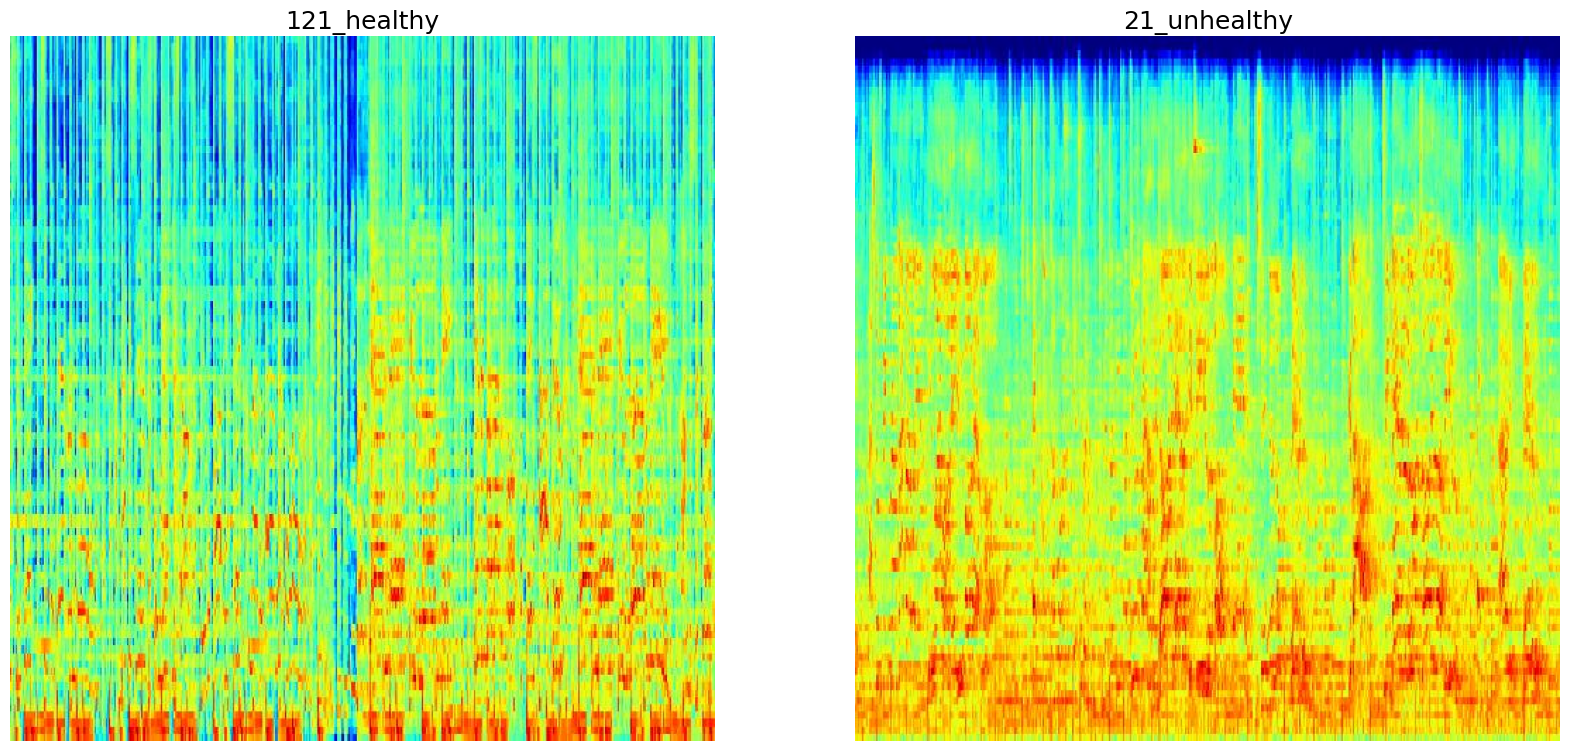

In [ ]:
f, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,10))

healthy_file = [file_ for file_ in sample_files if 'healthy' in file_][0]
unhealthy_file = [file_ for file_ in sample_files if 'unhealthy' in file_][0]

im = Image.open(IMG_DIR + healthy_file)
axarr[0].imshow(np.asarray(im))
axarr[0].axis('off')
axarr[0].set_title(healthy_file[:-4], fontsize=18)

im = Image.open(IMG_DIR + unhealthy_file)
axarr[1].imshow(np.asarray(im))
axarr[1].axis('off')
axarr[1].set_title(unhealthy_file[:-4], fontsize=18)

plt.show()


In [ ]:

conv_base = keras.applications.VGG16(include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 216, 216, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 216, 216, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 108, 108, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 108, 108, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 108, 108, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 54, 128)       0     

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

# 1-layer MLP with Dropout, BN
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1'))
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 2)                 1026      
                                                                 
Total params: 24153410 (92.14 MB)
Trainable params: 2415

In [ ]:
conv_base.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 2)                 1026      
                                                                 
Total params: 24153410 (92.14 MB)
Trainable params: 9438

In [ ]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array)  # Tidak perlu toarray()
    img_array = np.array(img_array) / 255.0  # Normalize RGB

    return img_array, np.array(label_array), np.array(idx_array)

In [ ]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:

            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array)

            batch_start += BATCH_SIZE
            batch_end += BATCH_SIZE

In [ ]:
optimizer = optimizers.Adam(learning_rate=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/transfer_learning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath,
                                       monitor='val_categorical_accuracy',
                                       verbose=0,
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print("Jumlah file pelatihan:", len(train_files))
print("Jumlah file validasi:", len(val_files))

Jumlah file pelatihan: 180
Jumlah file validasi: 10


In [ ]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files) // BATCH_SIZE + 1

history = model.fit_generator(generator=batch_generator(train_files, BATCH_SIZE),
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              class_weight=class_weights_dict,
                              validation_data=batch_generator(val_files, BATCH_SIZE),
                              validation_steps=VAL_STEPS,
                              callbacks=callbacks_list)

<ipython-input-14-d3176de65db1>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=batch_generator(train_files, BATCH_SIZE),
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


2/5 [===========>..................] - ETA: 0s - loss: 1.6616 - categorical_accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


3/5 [=================>............] - ETA: 0s - loss: 1.6728 - categorical_accuracy: 0.5521

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


4/5 [=======================>......] - ETA: 0s - loss: 1.6791 - categorical_accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.6878 - categorical_accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 7s 2s/step - loss: 1.6878 - categorical_accuracy: 0.5312 - val_loss: 1.5389 - val_categorical_accuracy: 0.9000
Epoch 2/10


<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2/5 [===========>..................] - ETA: 0s - loss: 1.6689 - categorical_accuracy: 0.5769 

<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


4/5 [=======================>......] - ETA: 0s - loss: 1.6081 - categorical_accuracy: 0.6466

<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.5904 - categorical_accuracy: 0.6689

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 6s 348ms/step - loss: 1.5904 - categorical_accuracy: 0.6689 - val_loss: 1.5044 - val_categorical_accuracy: 1.0000
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 1.4773 - categorical_accuracy: 0.7812

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


4/5 [=======================>......] - ETA: 0s - loss: 1.5340 - categorical_accuracy: 0.7328

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.5431 - categorical_accuracy: 0.7162

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 1s 343ms/step - loss: 1.5431 - categorical_accuracy: 0.7162 - val_loss: 1.4675 - val_categorical_accuracy: 1.0000
Epoch 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


3/5 [=================>............] - ETA: 0s - loss: 1.5163 - categorical_accuracy: 0.7143

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.5222 - categorical_accuracy: 0.7095

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 2s 360ms/step - loss: 1.5222 - categorical_accuracy: 0.7095 - val_loss: 1.4184 - val_categorical_accuracy: 0.9000
Epoch 5/10
1/5 [=====>........................] - ETA: 0s - loss: 1.5215 - categorical_accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


4/5 [=======================>......] - ETA: 0s - loss: 1.4904 - categorical_accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.5122 - categorical_accuracy: 0.7230

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 2s 406ms/step - loss: 1.5122 - categorical_accuracy: 0.7230 - val_loss: 1.3811 - val_categorical_accuracy: 0.9000
Epoch 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


2/5 [===========>..................] - ETA: 0s - loss: 1.4910 - categorical_accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.4860 - categorical_accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 1s 328ms/step - loss: 1.4860 - categorical_accuracy: 0.7500 - val_loss: 1.3517 - val_categorical_accuracy: 0.9000
Epoch 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


3/5 [=================>............] - ETA: 0s - loss: 1.4830 - categorical_accuracy: 0.7604

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.4748 - categorical_accuracy: 0.7625

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 3s 809ms/step - loss: 1.4748 - categorical_accuracy: 0.7625 - val_loss: 1.3261 - val_categorical_accuracy: 0.9000
Epoch 8/10
1/5 [=====>........................] - ETA: 0s - loss: 1.3389 - categorical_accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.3944 - categorical_accuracy: 0.8243

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 2s 559ms/step - loss: 1.3944 - categorical_accuracy: 0.8243 - val_loss: 1.3007 - val_categorical_accuracy: 0.9000
Epoch 9/10
1/5 [=====>........................] - ETA: 0s - loss: 1.4340 - categorical_accuracy: 0.6875

<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


3/5 [=================>............] - ETA: 0s - loss: 1.4288 - categorical_accuracy: 0.7262

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.4341 - categorical_accuracy: 0.7365

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 2s 360ms/step - loss: 1.4341 - categorical_accuracy: 0.7365 - val_loss: 1.2781 - val_categorical_accuracy: 0.9000
Epoch 10/10
2/5 [===========>..................] - ETA: 0s - loss: 1.3658 - categorical_accuracy: 0.7656

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


5/5 [==============================] - ETA: 0s - loss: 1.3765 - categorical_accuracy: 0.8041

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/l

5/5 [==============================] - 5s 1s/step - loss: 1.3765 - categorical_accuracy: 0.8041 - val_loss: 1.2579 - val_categorical_accuracy: 0.9000


In [ ]:
pickle_dir = 'pickle_files'
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir)

# Sekarang Anda dapat menyimpan file pickle ke direktori yang telah dibuat
with open(os.path.join(pickle_dir, 'transfer_learning_vgg16_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
with open('pickle_files/transfer_learning_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


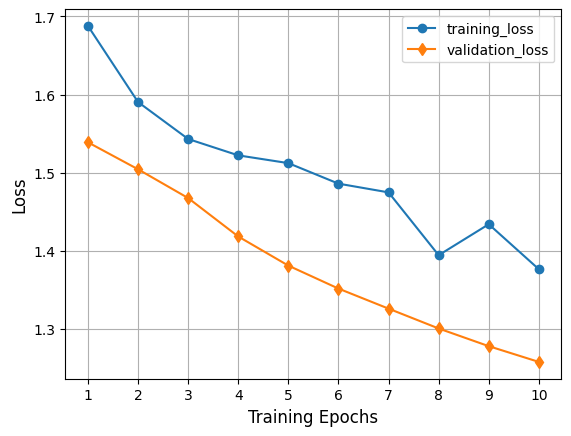

In [ ]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

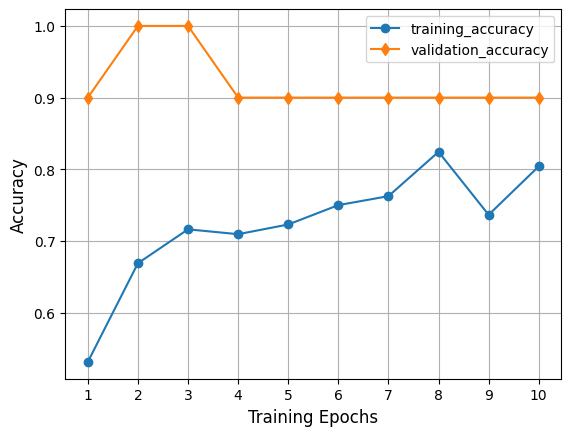

In [ ]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [ ]:
model = models.load_model(filepath='saved_models/transfer_learning_epoch_02_1.0000.h5')

In [ ]:
TEST_STEPS = len(test_files)//BATCH_SIZE+1
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE),
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

<ipython-input-23-1379c26fe64f>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE),
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-9-7c7c9c4952f6>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[5 1]
 [1 3]]


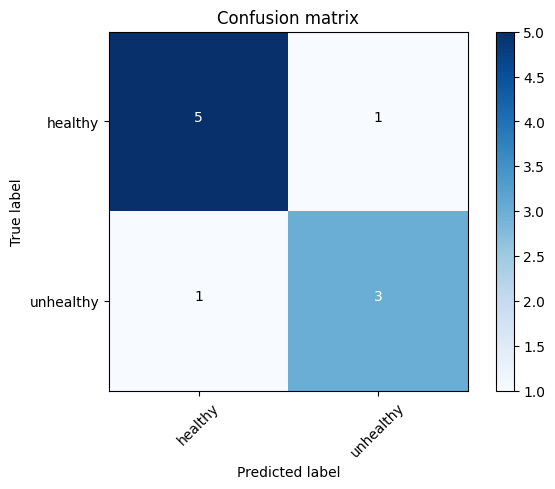

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred),
                      classes=label_dict.keys())

In [ ]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.80
Test Set F-score =  0.79


In [ ]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.917


<ipython-input-28-0069e7323f62>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


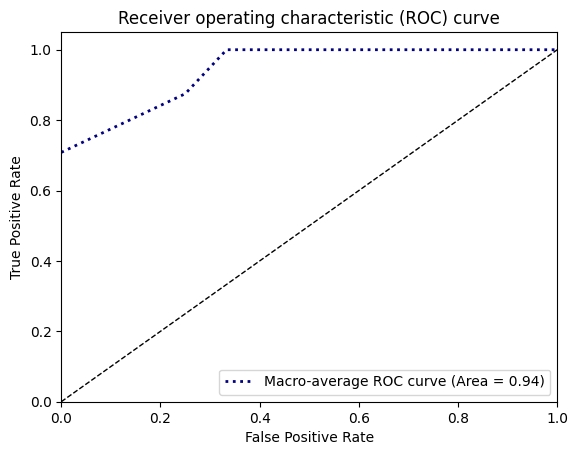

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!zip -r pickle_files.zip pickle_files

  adding: pickle_files/ (stored 0%)
  adding: pickle_files/transfer_learning_vgg16_history.pkl (deflated 48%)


In [ ]:
!zip -r saved_models.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/transfer_learning_epoch_06_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_02_1.0000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_07_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_03_1.0000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_05_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_09_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_08_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_01_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_04_0.9000.h5 (deflated 7%)
  adding: saved_models/transfer_learning_epoch_10_0.9000.h5 (deflated 7%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
